In [1]:
import sys
sys.path.append('../')
import torch.optim as optim
from dataset import *
from model import *
import torch.nn.init as init
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter

Train_epoch:0    MAE:107.31285446777343   Pure:107.31285446777343
Train_epoch:10    MAE:6.183217901992798   Pure:6.183217901992798
Test_epoch:10    MAE_test:12.764101643912708
Parameter containing:
tensor([[-1.2164, -2.1121,  2.0063]], device='cuda:0', requires_grad=True)


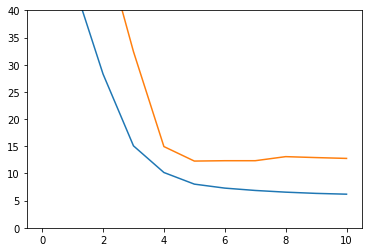

Train_epoch:20    MAE:6.023130777359008   Pure:6.023130777359008
Test_epoch:20    MAE_test:13.145453931424564
Parameter containing:
tensor([[-1.4178, -2.1482,  2.0085]], device='cuda:0', requires_grad=True)


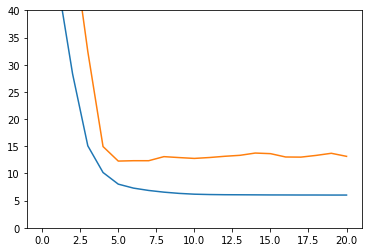

Train_epoch:30    MAE:6.000673789978027   Pure:6.000673789978027
Test_epoch:30    MAE_test:14.106399737227077
Parameter containing:
tensor([[-1.4901, -2.1612,  2.0134]], device='cuda:0', requires_grad=True)


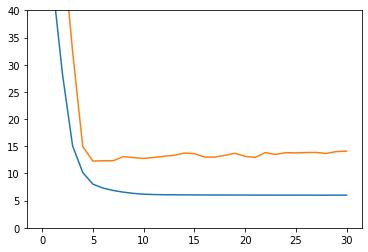

Train_epoch:40    MAE:6.001170035934448   Pure:6.001170035934448
Test_epoch:40    MAE_test:13.801186000958037
Parameter containing:
tensor([[-1.5190, -2.1604,  2.0159]], device='cuda:0', requires_grad=True)


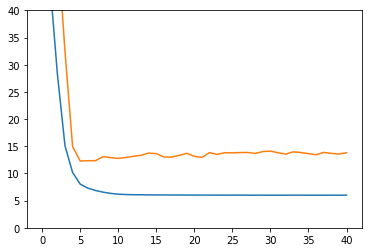

Train_epoch:50    MAE:5.9912437812805175   Pure:5.9912437812805175
Test_epoch:50    MAE_test:13.854225365879437
Parameter containing:
tensor([[-1.5415, -2.1608,  2.0139]], device='cuda:0', requires_grad=True)


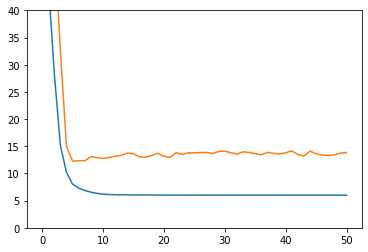

Train_epoch:60    MAE:5.984524850463867   Pure:5.984524850463867
Test_epoch:60    MAE_test:13.078494391883144
Parameter containing:
tensor([[-1.5891, -2.1594,  2.0222]], device='cuda:0', requires_grad=True)


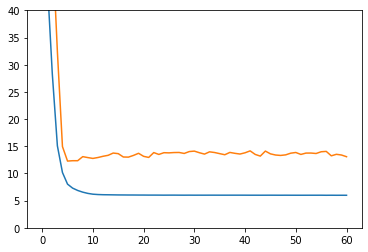

Train_epoch:70    MAE:5.977158988952636   Pure:5.977158988952636
Test_epoch:70    MAE_test:13.49597906837829
Parameter containing:
tensor([[-1.5978, -2.1639,  2.0218]], device='cuda:0', requires_grad=True)


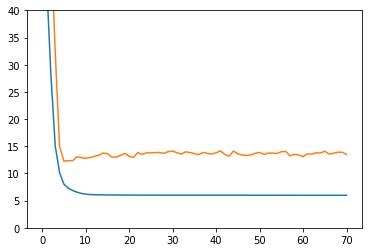

Train_epoch:80    MAE:5.972528393554687   Pure:5.972528393554687
Test_epoch:80    MAE_test:13.722044828981637
Parameter containing:
tensor([[-1.5923, -2.1635,  2.0231]], device='cuda:0', requires_grad=True)


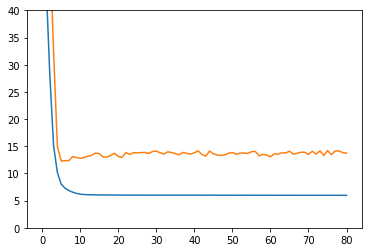

Train_epoch:90    MAE:5.973728620529175   Pure:5.973728620529175
Test_epoch:90    MAE_test:14.120410672391946
Parameter containing:
tensor([[-1.5798, -2.1643,  2.0209]], device='cuda:0', requires_grad=True)


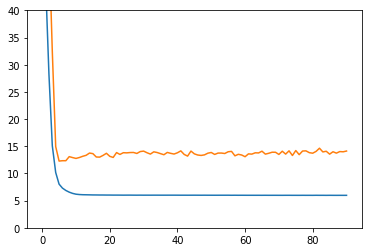

Train_epoch:100    MAE:5.9717976699829105   Pure:5.9717976699829105
Test_epoch:100    MAE_test:14.175670837061093
Parameter containing:
tensor([[-1.5622, -2.1619,  2.0233]], device='cuda:0', requires_grad=True)


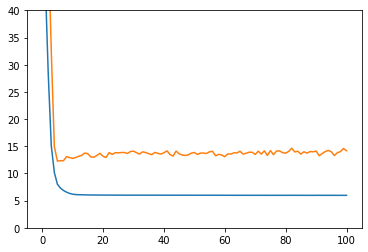

Train_epoch:110    MAE:5.97443265953064   Pure:5.97443265953064
Test_epoch:110    MAE_test:13.799459774273272
Parameter containing:
tensor([[-1.5411, -2.1590,  2.0228]], device='cuda:0', requires_grad=True)


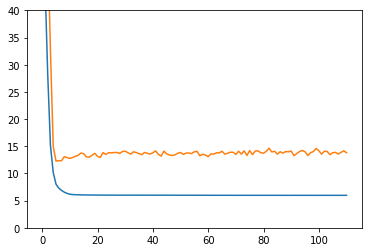

Train_epoch:120    MAE:5.967621119689942   Pure:5.967621119689942
Test_epoch:120    MAE_test:13.319382361329783
Parameter containing:
tensor([[-1.5291, -2.1551,  2.0256]], device='cuda:0', requires_grad=True)


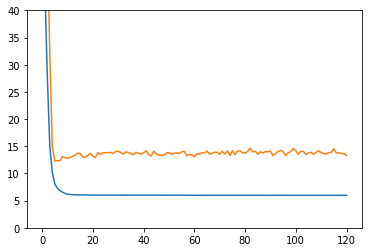

Train_epoch:130    MAE:5.974775737762451   Pure:5.974775737762451
Test_epoch:130    MAE_test:14.421149863221775
Parameter containing:
tensor([[-1.5122, -2.1608,  2.0231]], device='cuda:0', requires_grad=True)


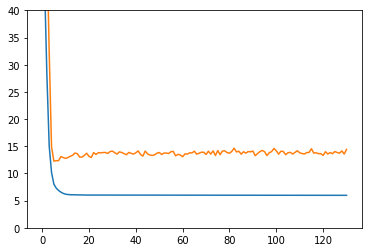

KeyboardInterrupt: 

In [2]:
s_or_d = "s"
unrelated_feature_number = 0
feature_number = 3

train_log = np.array([])
test_log = np.array([])

# writer = {
#     'train': SummaryWriter('../logs/OTO/train'), #必须要不同的writer
#     'test': SummaryWriter('../logs/OTO/test'),
# }

batchsize = 32
lambda_l1 = 0  # 正则化系数
lambda_selection = 0


criterion = nn.L1Loss()
criterion = criterion.cuda()

model = MLP_OTO(feature_number).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# adaptive learning rate
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)


# tmp = np.load("../data/simu_20000_0.1_90_140_train.npy")
# if s_or_d == 0:
#     max = np.max(tmp[:, 1004])
#     min = np.min(tmp[:, 1004])
# else:
#     max = np.max(tmp[:, 1005])
#     min = np.min(tmp[:, 1005])


train_dataset = Dataset("../data/features_train.npy", s_or_d, "train", unrelated_feature_number)
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataset = Dataset("../data/features_test.npy", s_or_d, "test", unrelated_feature_number)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

for epoch in range(501):
    
    # print(f"Learning Rate (Single LR): {optimizer.param_groups[0]['lr']}")
    
    model.train()

    loss_total = 0
    step = 0
    loss_pure = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()

        # print(data.shape)

        # target = (target - min) / (max - min)

        output = model(data)

        loss = criterion(output, target)
        
        loss_pure = loss_pure + loss.item()
        
        l1_regularization = torch.tensor(0.0).cuda()
        l1_selection = torch.tensor(0.0).cuda()
        
        for param in model.seq.parameters():
            l1_regularization += torch.norm(param, p=1)
        
        for param in model.OneToOneLayer.parameters():
            l1_selection += torch.norm(param, p=1)
        
        loss = loss + l1_regularization * lambda_l1 + l1_selection * lambda_selection

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_total = loss_total + loss.item()
        step = step + 1
    
    # scheduler.step()
    
    # writer["train"].add_scalar('FS', loss_total/step, epoch)  
    train_log = np.append(train_log, loss_total/step)
    
    # tmp = '../pth/tmp_%d_%.2f.pth' % (epoch, loss_total/step)
    
    if epoch % 10 == 0:
        # torch.save(model, tmp)
        print("Train_epoch:" + str(epoch) + "    MAE:" + str(loss_total/step) + "   Pure:" + str(loss_pure/step))

    loss_test = 0
    step = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.cuda(), target.cuda()
            output = model(data)

            # inv_norm
            # output = output * (max - min) + min

            loss = criterion(output, target)

            loss_test += loss.item()
            step += 1

        loss_mean = loss_test / step
        
        # writer["test"].add_scalar('FS', loss_mean, epoch) 
        test_log = np.append(test_log, loss_mean)
        
        if epoch % 10 == 0 and epoch != 0:
            print("Test_epoch:" + str(epoch) + "    MAE_test:" + str(loss_mean))
            # tmp_epoch = np.arange(epoch+1)
            # print(tmp_epoch)
            print(next(model.OneToOneLayer.parameters()))
            plt.plot(train_log)
            plt.plot(test_log)
            plt.ylim(0,40)
            plt.show()
            
            
# writer["train"].close()
# writer["test"].close()